### KBO 타자 OPS 모델링
### Background
- 2016년 관중수가 800만명을 돌파한 프로야구는, 명실공히 한국 프로스포츠 최고의 인기 종목입니다.
- 프로야구의 인기 데이터 분석에 대한 인식이 높아짐에 따라 국내 여러 구단에서 데이터 사이언스 역할의 수요가 늘고 있습니다.
- 특히 야구에서는 특정 선수의 성적 변동성이 해마다 매우 크기 때문에 내년 성적을 예측하기 어렵습니다.
- 정말 못할 것이라고 생각했던 선수도 막상 내년에는 잘하고, 많은 지표가 리그 상위권이었던 선수가 내년에는 그렇지 않은 경우가 많습니다.
- 본 대회는 야구 데이터로 불확실성 문제를 해결하기 위해 2019년 타자들의 상반기 성적 예측을 목표로 합니다.

### Description
- 2019년 타자들의 상반기 OPS를 예측하는 모델을 만들어 주세요. 2010년부터 1군 엔트리에 1번 이상 포함 되었던 타자들의 역대 정규시즌,
- 시범경기 성적 정보를 제공합니다(후반기 OPS 예측 대회는 전반기 종료 한 달 전 따로 오픈할 예정입니다)

### 데이터
- 약 350명의 타자들의 시즌별 성적, 생년월일, 몸무게, 키 등의 정보가 제공됩니다.

- KBO기록실( https://www.koreabaseball.com/Record/Player/HitterBasic/Basic1.aspx )과 같은 법적인 제약이 없는 외부 데이터 사용이 가능합니다.
- 2010년부터 1군 엔트리에 1번 이상 포함 되었던 타자들의 역대 정규시즌,

- ① Regular_Season_Batter.csv : KBO에서 활약한 타자들의 역대 정규시즌 성적을 포함하여 몸무게, 키 ,생년월일 등의 기본정보
- ② Regular_Season_Batter_Day_by_Day.csv: KBO에서 활약한 타자들의 일자 별 정규시즌 성적
- ③ Pre_Season_Batter.csv : KBO에서 활약한 타자들의 역대 시범경기(정규시즌 직전에 여는 연습경기) 성적
- ④ submission.csv : 참가자들이 예측해야 할 타자의 이름과 아이디 목록

### 목적 
- OPS 예측 (OPS 란 타자를 평가하는 기록)
- 2019년 타자들의 상반기 성적 예측을 목표로 합니다.

### 변수
- 포지션
- (1루   2루   3루  유격수  포수  우익수  좌익수  중견수  지명타자)
- ['1B', '2B', '3B', 'SS',  'C',   'RF',   'LF',   'CF',    'DH'] 

- G : 경기
- wOBA : 타자의 생산력을 측정하는데 최근 들어 널리 쓰이는 비율스탯으로 선형 회귀 분석을 이용해서 만든 지표
- wRC+ : wOBA에 기반해 계산되는 스탯 / 타율, 출루율, 장타율이 모두 0인 선수가 있다고 가정하고 생산성을 비교하는 스탯
- WAR+ : WAR은 Wins Above Replacement의 약자로 대체 선수 대비 승리 기여도라고도 한다. 대체선수에 비해 얼마나 많은 승리에 기여했는가를 나타내는 수치


### 2019년 KBO 타자 OPS 예측
### 1. Data Cleansing and Crawling

In [2]:
# matplotlib 한글 출력 가능하도록 만들기
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [7]:
# 데이터 크롤링 모듈
from selenium import webdriver
from bs4 import BeautifulSoup
import re

# 데이터 분석 모듈
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
import warnings
warnings.filterwarnings(action='ignore')

import os
os.chdir('C:/Users/urse/Desktop/dataset/Dacon_KBO_Hitter_OPS_Modeling')
submission = pd.read_csv("submission.csv")
reg = pd.read_csv("Regular_Season_Batter.csv", encoding='euc-kr') # 타자들의 역대 정규시즌 성적 및 기본정보
pre = pd.read_csv('Pre_Season_Batter.csv', encoding='euc-kr') # 프리시즌

In [8]:
# 정규시즌 데이터
print(reg.shape)
reg.head()

(2454, 29)


,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,...,3,0.519,0.383,9,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.902
1,1,강경학,2011,한화,0.000,2,1,0,0,0,...,0,0.000,0.000,1,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.000
2,1,강경학,2014,한화,0.221,41,86,11,19,2,...,1,0.349,0.337,6,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.686
3,1,강경학,2015,한화,0.257,120,311,50,80,7,...,3,0.325,0.348,15,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.673
4,1,강경학,2016,한화,0.158,46,101,16,16,3,...,5,0.257,0.232,7,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.489


In [10]:
# 프리시즌 데이터
print(pre.shape)
print(pre.head())

(1393, 29)
   batter_id batter_name  year team    avg   G  AB  R  H  2B  ...  GDP    SLG  \
0          0        가르시아  2018   LG  0.350   7  20  1  7   1  ...    1  0.550   
1          1         강경학  2011   한화  0.000   4   2  2  0   0  ...    0  0.000   
2          1         강경학  2014   한화      -   4   0  2  0   0  ...    0    NaN   
3          1         강경학  2015   한화  0.130  10  23  3  3   0  ...    0  0.130   
4          1         강경학  2016   한화  0.188  14  32  4  6   1  ...    0  0.281   

     OBP  E  height/weight      year_born   position  \
0  0.409  1     177cm/93kg  1985년 04월 12일  내야수(우투우타)   
1  0.500  0     180cm/72kg  1992년 08월 11일  내야수(우투좌타)   
2    NaN  0     180cm/72kg  1992년 08월 11일  내야수(우투좌타)   
3  0.286  2     180cm/72kg  1992년 08월 11일  내야수(우투좌타)   
4  0.212  0     180cm/72kg  1992년 08월 11일  내야수(우투좌타)   

                                   career  starting_salary    OPS  
0  쿠바 Ciego de Avila Maximo Gomez Baez(대)              NaN  0.959  
1                       광주대성초

In [ ]:
# https://dacon.io/competitions/official/62540/talkboard/65418?page=3&dtype=recent&ptype=pub
# STATIZ같은 경우에는 데이터 이용을 원할시 출처를 분명히 하라고 명시되어 있기 때문에, 가능합니다.
# 출처는 (출처 표기 : statiz.co.kr / 스탯티즈)   이렇게 표기하시면 됩니다.
# https://dacon.io/competitions/official/62540/talkboard/67135?page=3&dtype=recent&ptype=pub // 야구 용어 잘 정리되어있다고 함

### 참고사진
![hitter_table](./img/hitter_table.PNG)

In [201]:
# SATAIZ 크롤링
# 가상 웹드라이버 불러오기
# chromedriver.exe가 크롬 버젼에 맞게 설치 되어 있어야 함
driver = webdriver.Chrome('C:/Users/urse/Anaconda3/envs/untitled/Lib/site-packages/chromedriver.exe')

import time
all_time = 0; # 총 걸린 시간

# 크롤링
for i in range(86):
############################ 크롤링 모델 생성
    start_time = time.time() # 시간측정용
    # 1982년 부터 2018년 까지 statiz에 기록된 선수들 필터링 (총 8558명)
    url = 'http://www.statiz.co.kr/stat.php?mid=stat&re=0&ys=1982&ye=2018&sn=100&pa={}'.format(i*100)
    
    driver.get(url) # 해당 url에 접근
    #driver.implicitly_wait(10) # = time.sleep 
    time.sleep(1)
    # time.sleep(5) - process 단에서 정확히 5초 멈춘다
    # implicity_wait(5) - 2초만에 발견시 3초 안기다리고 계속 진행 / 셀레니움 자체 코드로 좀더 최적화
    # implicity_wait 가 좀더 효율적이라는데 한 10번은 실패한듯 ? ㅎ
    
    html = driver.find_element_by_xpath('//*[@id="mytable"]/tbody').get_attribute("innerHTML") #기록 table을 str형태로 저장
    soup = BeautifulSoup(html, 'html.parser') #str 객체를 BeautifulSoup 객체로 변경
    
############################ 선수 테이블 가져오기 
    # 선수들 한명한명씩 가져오기 
    # findall 은 패턴과 매칭되는 모든 문자열 리스트로 넘겨줌
    temp = [i.text.strip() for i in soup.findAll("tr")] #tr 태그에서, text만 저장하기
    temp = pd.Series(temp) #list 객체에서 series 객체로 변경

    # '순'이나 'W'로 시작하는 row 제거 (-> temp[0], temp[1] 제거) ==> column 들 그냥 다 날리고 다시 만들어줌.
    ### 'temp[0] : 순\n이름\n팀\n정렬G타석타수득점안타2타3타홈런루타타점도루도실볼넷사구고4삼진병살희타희비비율WAR*WPA'
    ### 'temp[1] : WAR*타율출루장타OPSwOBAwRC+'  ==> 아마도 단어도 다 붙어있으니까 다시 하려고

    # 즉, 선수별 기록만 남기고, index를 reset 해주기
    # 정규식이라 [] 안에 있는 '순'이나 'W'와 매치 면 됨. (=해당 반복이있으면됨)
    temp = temp[~temp.str.match("[순W]")].reset_index(drop=True)  
    # https://nachwon.github.io/regular-expressions/ - 정규표현식 링크

    #띄어쓰기 기준으로 나눠서 dataframe으로 변경
    temp = temp.apply(lambda x: pd.Series(x.split(' '))) 
    
    # 선수 팀 정보 이후 첫번째 기록과는 space 하나로 구분, 그 이후로는 space 두개로 구분이 되어 있음 
    # 그래서 space 하나로 구분을 시키면, 빈 column들이 존재 하는데, 해당 column들 제거 
    ### 공백 열이 만들어 지는데 해당 열 제거 ## g랑 타석, 타수랑 득점 사이에 공백 열 하나 더 이는데
    temp = temp.replace('', np.nan).dropna(axis=1) 

    #WAR 정보가 들어간 column이 2개 있다. (index가 1인 column과, 제일 마지막 column)
    #그 중에서 index가 1인 columm 제거  # WAR 가 같은게 두번들어감
    temp = temp.drop(1, axis=1)
    
    #선수 이름 앞의 숫자 제거 
    # ex)101이만수91삼C ==> 101 제거
    temp[0] = temp[0].str.replace("^\d+", '') # ^:뒷문자가시작(숫자) / \d : 숫자 / + :반복  
    
############################ 선수들 생일 정보 column 만들기
    # 선수들의 생년 정보가 담긴 tag들 가지고 오기
    soup.findAll('tr') # html 에서 행임 행

    # <tr> 행별로 찾고 / <a> tag의 href옵션중에 birth 생년 항목이 있다면 그 <a> tag를 가져와라
    # 원래 <a> tag는 하이퍼링크 태그     
    birth = [i.find("a") for i in soup.findAll('tr') if 'birth' in i.find('a').attrs['href']]


    # 선수들의 생일 정보가 담긴 tag들 가지고 오기
    birth = [i.find("a") for i in soup.findAll('tr') if 'birth' in i.find('a').attrs['href']]

    # tag내에서, 생일 날짜만 추출하기 
    # 정규식 객체를 리턴 / re.compile(검색할문자열)
    # 숫자형식의 값들찾을 객체를 지정
    p = re.compile("\d{4}\-\d{2}\-\d{2}") # 숫자 4개, 숫자 2개, 숫자 2개

    # 만들어진 정규식 형태로 찾아서 birth 구성
    birth = [p.findall(i.attrs['href'])[0] for i in birth]

    # 생일 column 추가
    temp['생일'] = birth
    
############################ page별 완성된 dataframe을 계속해서 result에 추가 
    if i == 0:
        result = temp
    else:
        result = result.append(temp)
        result = result.reset_index(drop=True)
    end_time = time.time(); during_time = np.round(end_time - start_time,2)
    print(i, "완료", during_time, '초')
    all_time += during_time
print('최종걸린시간 : ',all_time, '초')

############################ 완성된 dataframe 에 컬럼명 추가 
#column 명 정보 저장 (칼럼 없앴었으니까 다시 저장)
# tr -> th(맨윗줄일때만) -> td
columns = ['선수'] + [i.text for i in soup.findAll("tr")[0].findAll("th")][4:-3] + ['타율', '출루', '장타', 'OPS', 'wOBA', 'wRC+', 'WAR+', '생일']

#column 명 추가
result.columns = columns

#webdriver 종료
driver.close()

print("최종 완료")

0 완료 6.81 초
1 완료 3.24 초
2 완료 3.56 초
3 완료 3.34 초
4 완료 3.27 초
5 완료 3.65 초
6 완료 3.69 초
7 완료 3.41 초
8 완료 3.91 초
9 완료 3.38 초
10 완료 3.45 초
11 완료 3.4 초
12 완료 2.9 초
13 완료 4.72 초
14 완료 3.43 초
15 완료 3.33 초
16 완료 2.72 초
17 완료 3.13 초
18 완료 3.06 초
19 완료 2.93 초
20 완료 2.81 초
21 완료 2.93 초
22 완료 3.38 초
23 완료 2.7 초
24 완료 3.01 초
25 완료 2.55 초
26 완료 3.73 초
27 완료 2.96 초
28 완료 2.98 초
29 완료 3.35 초
30 완료 4.15 초
31 완료 3.65 초
32 완료 3.85 초
33 완료 2.92 초
34 완료 3.14 초
35 완료 3.2 초
36 완료 3.56 초
37 완료 2.48 초
38 완료 2.43 초
39 완료 3.42 초
40 완료 2.75 초
41 완료 2.35 초
42 완료 2.3 초
43 완료 2.12 초
44 완료 2.51 초
45 완료 2.17 초
46 완료 2.37 초
47 완료 2.37 초
48 완료 2.31 초
49 완료 2.35 초
50 완료 2.33 초
51 완료 4.34 초
52 완료 2.68 초
53 완료 3.04 초
54 완료 3.41 초
55 완료 3.51 초
56 완료 2.59 초
57 완료 3.76 초
58 완료 3.47 초
59 완료 2.3 초
60 완료 2.45 초
61 완료 2.19 초
62 완료 2.66 초
63 완료 2.52 초
64 완료 2.93 초
65 완료 2.45 초
66 완료 2.69 초
67 완료 2.14 초
68 완료 4.5 초
69 완료 3.28 초
70 완료 3.27 초
71 완료 4.48 초
72 완료 5.36 초
73 완료 3.14 초
74 완료 2.84 초
75 완료 2.72 초
76 완료 4.01 초
77 완료 2.7 초
78 완

In [202]:
#결과값 저장해두기
# result.to_csv("statiz_origin.csv")

# 저장해둔 데이터 불러오기
result = pd.read_csv("statiz_origin.csv", index_col=0)

print(result.shape, '\n', result.dtypes)
result.head()

(8557, 28) 
 선수       object
G         int64
타석        int64
타수        int64
득점        int64
안타        int64
2타        int64
3타        int64
홈런        int64
루타        int64
타점        int64
도루        int64
도실        int64
볼넷        int64
사구        int64
고4        int64
삼진        int64
병살        int64
희타        int64
희비        int64
타율      float64
출루      float64
장타      float64
OPS     float64
wOBA    float64
wRC+    float64
WAR+    float64
생일       object
dtype: object


,선수,G,타석,타수,득점,안타,2타,3타,홈런,루타,...,희타,희비,타율,출루,장타,OPS,wOBA,wRC+,WAR+,생일
0,이종범94해SS,124,561,499,113,196,27,5,19,290,...,1,4,0.393,0.452,0.581,1.033,0.462,198.3,11.77,1970-08-15
1,테임즈15N1B,142,595,472,130,180,42,5,47,373,...,0,7,0.381,0.498,0.790,1.288,0.530,222.3,10.71,1986-11-10
2,심정수03현RF,133,601,460,110,154,16,1,53,331,...,0,8,0.335,0.478,0.720,1.197,0.498,210.7,10.19,1975-05-05
3,이종범97해SS,125,577,484,112,157,28,3,30,281,...,0,3,0.324,0.428,0.581,1.009,0.431,173.2,9.70,1970-08-15
4,이종범96해SS,113,525,449,94,149,28,1,25,254,...,0,2,0.332,0.425,0.566,0.991,0.440,184.6,9.52,1970-08-15


### 2. 데이터 전처리
### 선수정보

In [203]:
# 이름 분리 해서, '이름' column 추가
# [ㄱ-힣] -> 모든 한글 / + : 반복
# series 형 리턴이고 x[0] 이 이름
result['이름'] = result['선수'].str.findall("^[ㄱ-힣]+").apply(lambda x: x[0]) 

# 기존 '선수' column 에 있던 이름 정보 제거
# 이종범96해ss => 96해ss 
result['선수'] = result.apply(lambda x: x['선수'].replace(x['이름'], ''), axis=1)

# '시즌' column 생성
result['시즌'] = result['선수'].apply(lambda x: x[:2]) # 시즌 (94, 97, 03 등등)

# 기존 '선수' column 에 있던 시즌 정보 제거
# 96해ss => 해ss
result['선수'] = result.apply(lambda x: x['선수'].replace(x['시즌'],''), axis=1)

# 년도를 4자리 숫자로 바꾸어주기 ex) 98 ->; 1998, 15 ->; 2015
result['시즌'] = result['시즌'].apply(lambda x: int("20"+ x) if int(x) < 30 else int("19"+x))

# 포지션  ( 1루   2루   3루  유격수  포수  우익수  좌익수  중견수  지명타자
position = ['1B', '2B', '3B', 'SS',  'C',   'RF',   'LF',   'CF',    'DH'] 

# 포지션 여부 확인
# 해ss , 삼c ==> 분리
# 뒤에서 2자리가 isin이면 (ss, 3B) or 뒤에서 1자리 (C)
result['포지션여부'] = result['선수'].apply(lambda x : (np.isin(x[-2:], position) or np.isin(x[-1:], position))) 
c = len(result.loc[result['포지션여부'] == False])
print('포지션여부 Nan 갯수', c) # True, False 로 나타냄.

# 포지션 분리 
# 포지션 리스트에 있다면 뒤에서 2칸 제거 없다면 1칸 제거
result['포지션'] = result['선수'].apply(lambda x: x[-2:] if x[-2:] in position else x[-1:])

#포지션이 기록 되어 있지 않으면, 포지션 항목에 nan값 넣기
result.loc[result['포지션여부']==False, '포지션'] = np.nan

#statiz 사이트에, 2015시즌 조홍석 데이터에 생일이 기록 안되어 있음, 해당 시즌의 생일 추가 
# 찾은게 신기;;
result.loc[(result.이름 =='조홍석'),'생일']
result.loc[(result.이름 =='조홍석')&(result.시즌 ==2015),'생일'] = '1990-02-23'

# 조홍석 넣은 결과 조회
result[(result.이름 =='조홍석')&(result.시즌 ==2015)].생일

포지션여부 Nan 갯수 2384


6466    1990-02-23
Name: 생일, dtype: object

In [204]:
# 팀 column 생성  (ex - 해, N, 현, 삼, 롯, k 등등)
# 포지션이 str 이면 선수에서 포지션 지워서 팀만 남기고 없으면 그냥 그대로 
result['팀'] = result.apply(lambda x: x['선수'].replace(x['포지션'],'') if type(x['포지션'])==str else x['선수'], axis=1)

# 해당 시즌에서의 나이 column 생성 
result['나이'] = result.apply(lambda x: x['시즌'] - int(x['생일'][:4]) + 1, axis=1)

In [205]:
# 선수별 고유 아이디 부여
# (이종범, 1970-08-15 ==> 2) 등의 숫자로

info = result[['이름', '생일']].apply(lambda x: tuple(x), axis=1)

# dictionary 로 이름, 생일 묶어서 만들고 unique()로 뽑아서 인덱스 부여
player_id = {}
for i,j in enumerate(info.unique()):
    player_id[j] = i # unique()로 뽑아서 인덱스 부여

# 부여한 인덱스를 바탕으로 ID column 생성
result['ID'] = result.apply(lambda x: player_id[tuple([x['이름'], x['생일']])], axis=1)
result['ID']

0          0
1          1
2          2
3          0
4          0
        ... 
8552     470
8553     889
8554    1792
8555       0
8556     419
Name: ID, Length: 8557, dtype: int64

In [206]:
# submission에는 있지만, statiz에는 없는 이름 확인
# 선수가 이름을 개명하여 submission과 statiz에 다르게 기록됨
# statiz가 홈페이지를 업데이트를 할 때마다, 그리고 선수들이 개명을 할 때마다 다른 값이 나오므로,
# 해당 코드를 돌릴 때마다 이름이 다르게 나올 수 있음 
# 윤여운 -> 윤수강 (submission : 윤수강 / statiz : 윤여운)
# 이유찬 -> 이병휘 (submission : 이병휘 / statiz : 이유찬)

# submission에 있는 것중 result에 없는 것 찾음.
submission[~np.isin(submission['batter_name'], result['이름'])]

# 이름 변경
result['이름'] = result['이름'].replace("윤여운", "윤수강").replace('이유찬', '이병휘')
result.head()

,선수,G,타석,타수,득점,안타,2타,3타,홈런,루타,...,wRC+,WAR+,생일,이름,시즌,포지션여부,포지션,팀,나이,ID
0,해SS,124,561,499,113,196,27,5,19,290,...,198.3,11.77,1970-08-15,이종범,1994,True,SS,해,25,0
1,N1B,142,595,472,130,180,42,5,47,373,...,222.3,10.71,1986-11-10,테임즈,2015,True,1B,N,30,1
2,현RF,133,601,460,110,154,16,1,53,331,...,210.7,10.19,1975-05-05,심정수,2003,True,RF,현,29,2
3,해SS,125,577,484,112,157,28,3,30,281,...,173.2,9.70,1970-08-15,이종범,1997,True,SS,해,28,0
4,해SS,113,525,449,94,149,28,1,25,254,...,184.6,9.52,1970-08-15,이종범,1996,True,SS,해,27,0


In [207]:
# numeric data로 변환
# G, 타석 ~ WAR+   수치값들 float 형으로 변환
float_columns = result.iloc[:,1:27].columns
result[float_columns] = result[float_columns].astype(float).fillna(0)

# 필요한 features 선택 
# 순서 바꿈
cols = ['ID', '이름', '생일', '팀', '시즌', '포지션', '나이'] + list(float_columns)
result = result[cols]
result.head()

,ID,이름,생일,팀,시즌,포지션,나이,G,타석,타수,...,병살,희타,희비,타율,출루,장타,OPS,wOBA,wRC+,WAR+
0,0,이종범,1970-08-15,해,1994,SS,25,124.0,561.0,499.0,...,2.0,1.0,4.0,0.393,0.452,0.581,1.033,0.462,198.3,11.77
1,1,테임즈,1986-11-10,N,2015,1B,30,142.0,595.0,472.0,...,7.0,0.0,7.0,0.381,0.498,0.790,1.288,0.530,222.3,10.71
2,2,심정수,1975-05-05,현,2003,RF,29,133.0,601.0,460.0,...,14.0,0.0,8.0,0.335,0.478,0.720,1.197,0.498,210.7,10.19
3,0,이종범,1970-08-15,해,1997,SS,28,125.0,577.0,484.0,...,9.0,0.0,3.0,0.324,0.428,0.581,1.009,0.431,173.2,9.70
4,0,이종범,1970-08-15,해,1996,SS,27,113.0,525.0,449.0,...,4.0,0.0,2.0,0.332,0.425,0.566,0.991,0.440,184.6,9.52


### 3. Visualization


In [208]:
print("<전체 column 타입확인>\n\n",result.dtypes.value_counts())
print("<object type columns>\n\n",result.columns[result.dtypes=='object'])

<전체 column 타입확인>

 float64    26
object      4
int64       3
dtype: int64

<object type columns>

 Index(['이름', '생일', '팀', '포지션'], dtype='object')


In [209]:
# Find correlations with the target and sort
# OPS 와의 상관관계 
correlations = result.corr()['OPS'].sort_values()

# Display correlations
# 제일 좋은 상관관계 / 제일 나쁜 상관관계
print('Most Positive Correlations:\n', correlations.tail(11))
print('\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 타수      0.605570
안타      0.607197
타석      0.607948
루타      0.609291
G       0.629092
wRC+    0.840112
출루      0.903542
wOBA    0.940022
타율      0.967632
장타      0.982628
OPS     1.000000
Name: OPS, dtype: float64

Most Negative Correlations:
 ID   -0.584776
시즌   -0.087072
나이    0.167612
희타    0.283358
도루    0.318930
고4    0.343673
3타    0.353387
도실    0.380534
사구    0.452546
희비    0.466973
Name: OPS, dtype: float64


### OPS와 높은 상관관계
- ==> 장타, 타율, wOBA, 출루, wRC+, G,루타, 타석,안타

### OPS와 낮은 상관관계
- ==> 나이, 희타, 도루, 고4(고의4구), 3타, 도실(도루실수), 사구, 희비 

Text(0.5, 1.0, 'Top 10 correlations with OPS')

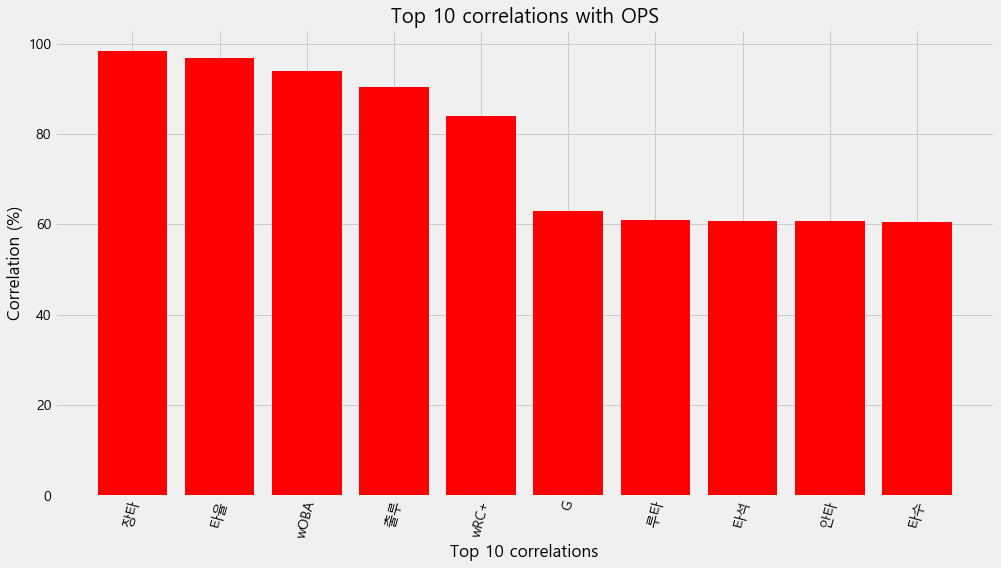

In [210]:
# 상관관계 높은 순 시각화
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,8))

plt.bar(correlations.tail(11)[:-1].index.astype(str)[::-1], 100*correlations.tail(11)[:-1][::-1],color='r')

# Plot labeling
plt.xticks(rotation=75) ; plt.xlabel('Top 10 correlations'); plt.ylabel('Correlation (%)');
plt.title('Top 10 correlations with OPS')

Text(0.5, 1.0, 'Low 8 correlations with OPS')

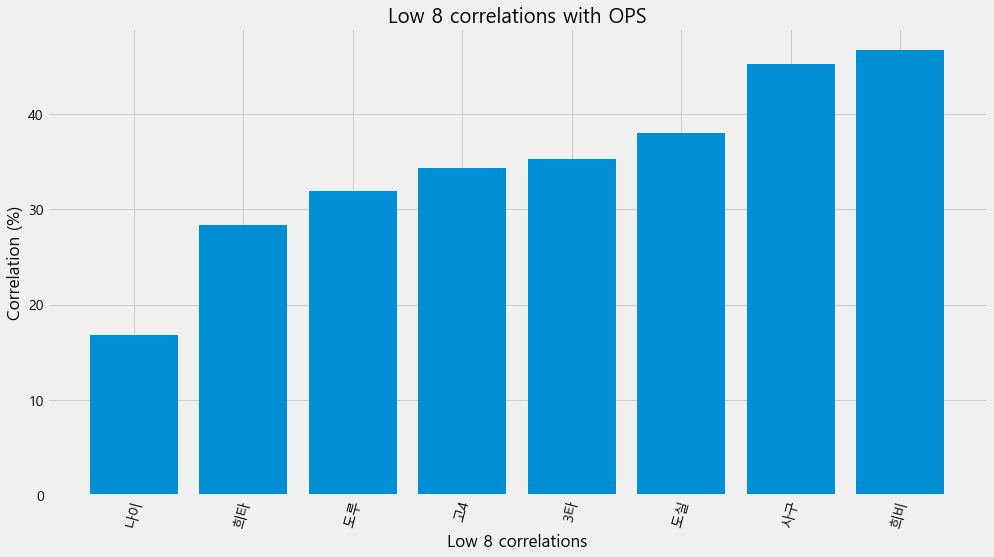

In [211]:
# 상관관게 낮은 순 시각화
plt.figure(figsize=(15,8))

plt.bar(correlations.head(10)[2:].index.astype(str), 100*correlations.head(10)[2:])

# Plot labeling
plt.xticks(rotation=75) ; plt.xlabel('Low 8 correlations'); plt.ylabel('Correlation (%)')
plt.title('Low 8 correlations with OPS')

Top 5. High correlation with 'OPS' Pair Plot
        OPS     장타     타율   wOBA     출루   wRC+
0     1.033  0.581  0.393  0.462  0.452  198.3
1     1.288  0.790  0.381  0.530  0.498  222.3
2     1.197  0.720  0.335  0.498  0.478  210.7
3     1.009  0.581  0.324  0.431  0.428  173.2
4     0.991  0.566  0.332  0.440  0.425  184.6
...     ...    ...    ...    ...    ...    ...
8552  0.465  0.237  0.178  0.207  0.228    1.8
8553  0.376  0.190  0.138  0.166  0.185  -16.1
8554  0.376  0.175  0.124  0.175  0.201  -15.1
8555  0.426  0.209  0.174  0.199  0.217    8.0
8556  0.425  0.188  0.162  0.198  0.237   17.3

[8557 rows x 6 columns]


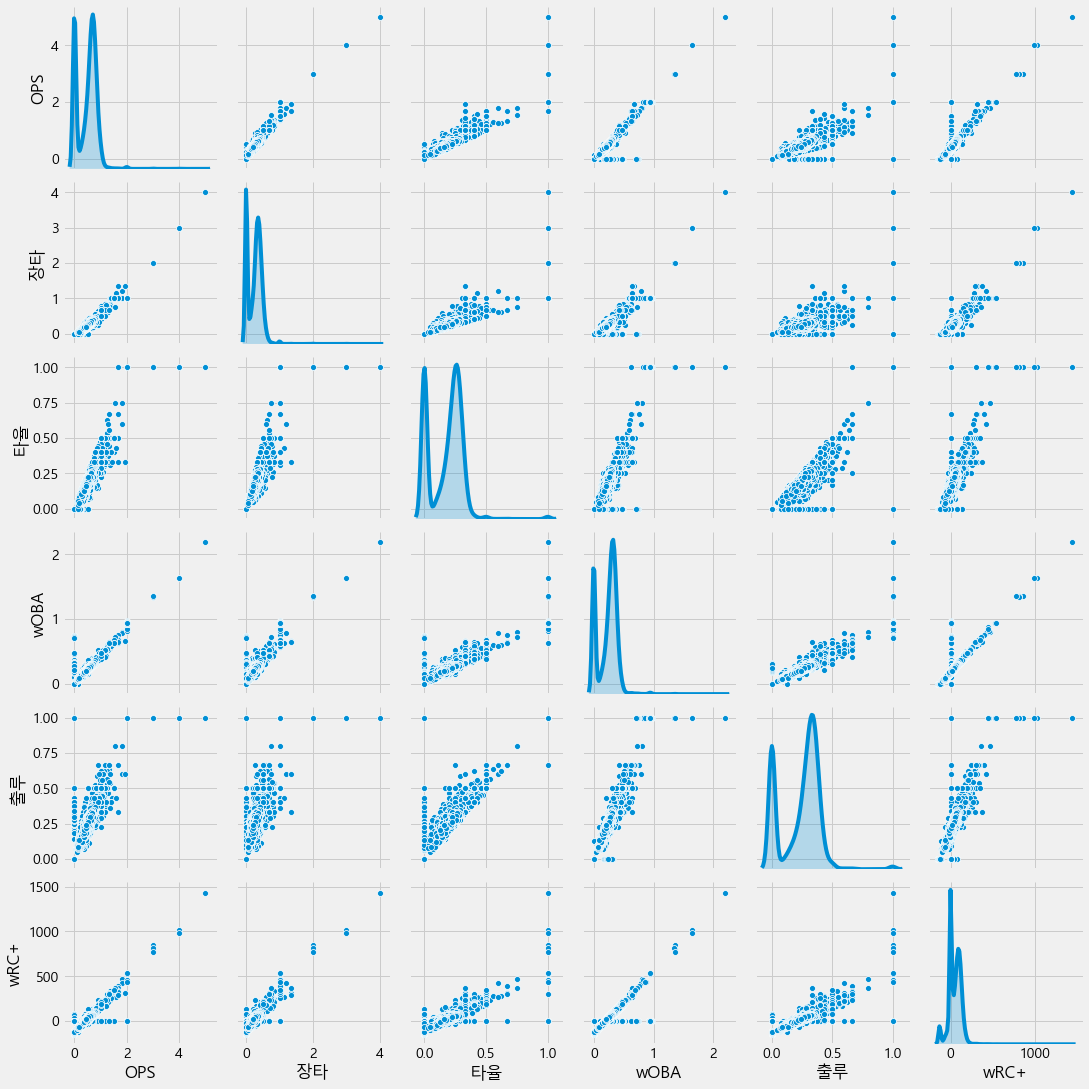

In [212]:
#Top 5. High correlation with 'OPS' Pair Plot
print("Top 5. High correlation with 'OPS' Pair Plot")
high_corr = result.loc[:,list(correlations.tail(6)[::-1].index)]
sns.pairplot(high_corr,diag_kind='kde')
plt.show()

Top5. Low correlation with 'OPS' Pair Plot
        OPS  나이    희타    도루    고4   3타
0     1.033  25   1.0  84.0  14.0  5.0
1     1.288  30   0.0  40.0  11.0  5.0
2     1.197  29   0.0   6.0  17.0  1.0
3     1.009  28   0.0  64.0  30.0  3.0
4     0.991  27   0.0  57.0  15.0  1.0
...     ...  ..   ...   ...   ...  ...
8552  0.465  29  11.0   7.0   0.0  3.0
8553  0.376  28  12.0   0.0   0.0  0.0
8554  0.376  21   9.0   0.0   0.0  0.0
8555  0.426  38  10.0   3.0   0.0  0.0
8556  0.425  36  25.0   2.0   1.0  1.0

[8557 rows x 6 columns]


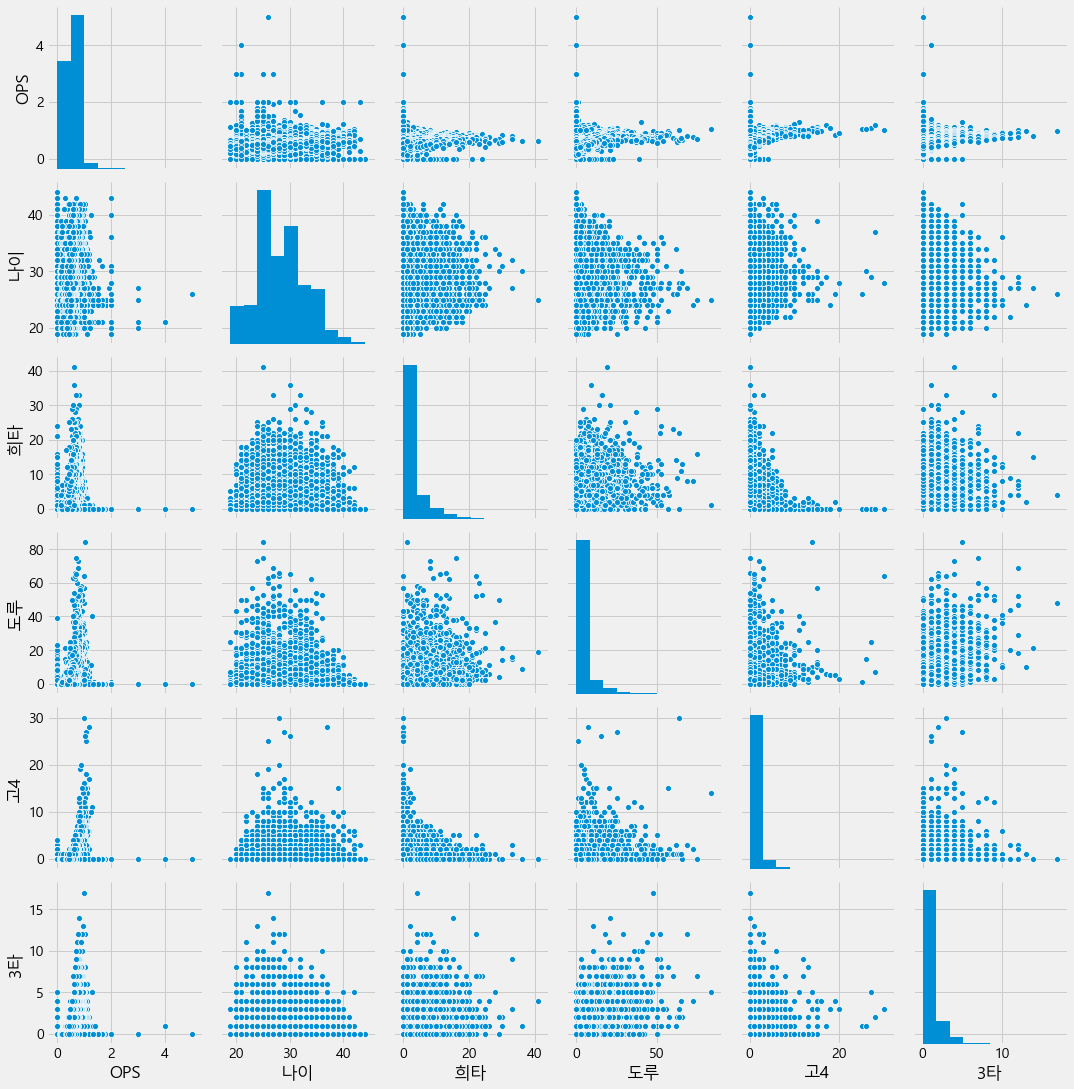

In [215]:
# Top5. Low correlation with 'OPS' Pair Plot
print("Top5. Low correlation with 'OPS' Pair Plot")
low_corr = result.loc[:,['OPS']+list(correlations.head(7)[2:].index)]
print(low_corr)
sns.pairplot(low_corr)#, diag_kind='kde')
plt.show()

- OPS와 선형성을 보이는 변수들이 있음
- OPS의 분포는 좁은 것에 비해서 상관성이 낮은 변수들은 분포가 넓음 (OPS 예측에 큰 도움이 안됨)


Text(0.5, 1.0, '포지션별 OPS violinplot')

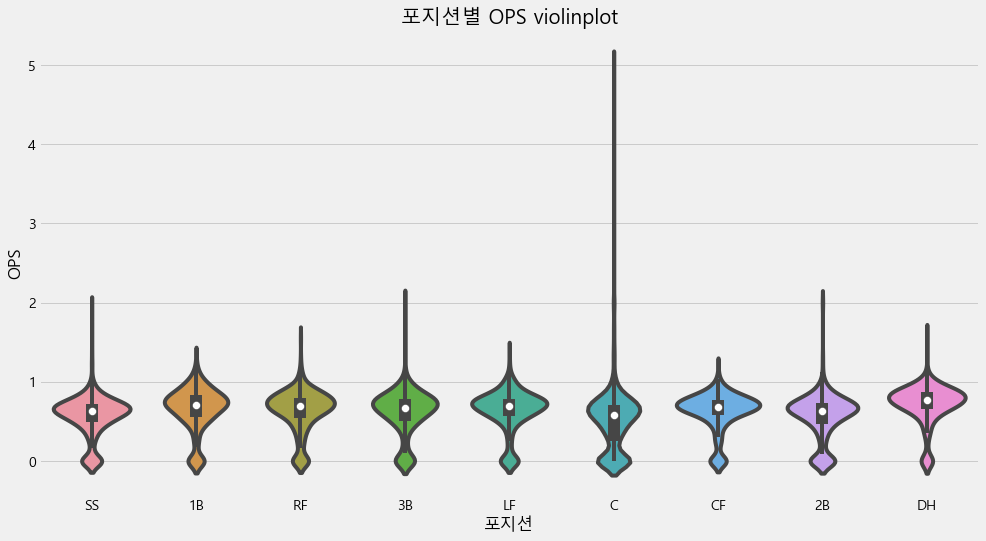

In [216]:
# dtype이 object인 것과 OPS 추출
result_obj=result.loc[:,list(result.columns[result.dtypes=='object'])+['OPS']]

# 포지션별 OPS violinplot 그려보기
plt.figure(figsize=(15,8))
sns.violinplot(x='포지션',y='OPS',data=result_obj)
plt.title("포지션별 OPS violinplot")

- violinplot: Box plot(분위수 확인)과 KDE plot(데이터의 분포 확인)을 동시에 할 수 있다
- C (포수) 포지션의 경우 다른 포지션에 비해서 outlier가 매우 큰 선수가 있는 것으로 보인다.

### 4. Feature Engineering

In [226]:
# 1루타 feature 생성
result['1타'] = result['안타'] - result['2타'] - result['3타'] - result['홈런']

# 사용 features 명시
infos = ['ID','이름','생일','팀','시즌','포지션','나이']
stats = ['G','타수','득점','안타','1타','2타','3타','홈런','루타','타점','도루','도실','볼넷','사구','고4','삼진'\
        ,'병살','희타','희비','타율','출루','장타','OPS','wOBA','wRC+','WAR+']

# 해당 시즌 이전까지의 누적 기록
def get_cumulative(player_id, season, stat=stats ,df=result):
    try: # 예외 처리 문 - 실행중 오류가 발생했을 때 except 실행 (Name error, value error등등)
        
        # 해당 시즌까지 (=이전의 ) stat들을 result_cum에 저장하고
        result_cum = df[(df['ID']==player_id) & (df['시즌'] < season)][stat]
        result_cum = result_cum.mean() # 해당을 평균
        
    # 잘못된값이면 전부 nan 처리
    except:
        result_cum = [np.nan for i in stat]
        result_cum = pd.Series(result_cum)    
    return result_cum

# 모든 stats에 대한 누적 stat
# G_누적 / 타수_누적 / 득점 누적 ...... WAR+_누적
stats_cum = [i + '_누적' for i in stats]

# 누적 stat 데이터프레임에 반영 (id = 정수(0, 1, 2...) / 시즌 = 년도)
result[stats_cum] = result.apply(lambda x: get_cumulative(x['ID'], x['시즌']), axis=1)
result[stats_cum]

,G_누적,타수_누적,득점_누적,안타_누적,1타_누적,2타_누적,3타_누적,홈런_누적,루타_누적,타점_누적,...,병살_누적,희타_누적,희비_누적,타율_누적,출루_누적,장타_누적,OPS_누적,wOBA_누적,wRC+_누적,WAR+_누적
0,126.000000,475.000000,85.000000,133.000000,97.000000,16.000000,4.000000,16.000000,205.000000,53.000000,...,11.000000,8.000000,4.000000,0.280000,0.331000,0.432000,0.762000,0.350000,127.400000,6.140000
1,125.000000,443.000000,95.000000,152.000000,79.000000,30.000000,6.000000,37.000000,305.000000,121.000000,...,6.000000,0.000000,6.000000,0.343000,0.422000,0.688000,1.111000,0.464000,168.300000,6.320000
2,102.111111,356.666667,58.666667,105.111111,63.888889,18.777778,1.333333,21.111111,189.888889,67.444444,...,7.888889,0.444444,3.111111,0.276444,0.356778,0.503000,0.859667,0.377111,133.700000,3.625556
3,106.500000,415.500000,85.750000,139.000000,96.750000,20.250000,3.000000,19.000000,222.250000,60.250000,...,5.500000,2.250000,3.250000,0.332750,0.401250,0.541250,0.942250,0.421000,173.050000,8.115000
4,104.333333,404.333333,83.000000,135.666667,97.333333,17.666667,3.666667,17.000000,211.666667,55.000000,...,6.000000,3.000000,3.666667,0.333000,0.393333,0.533000,0.926000,0.414667,169.200000,7.646667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8552,68.166667,166.666667,25.500000,43.500000,37.833333,2.833333,2.500000,0.333333,52.333333,12.666667,...,1.666667,13.000000,1.666667,0.197000,0.243000,0.235167,0.477833,0.215500,18.366667,0.266667
8553,75.500000,128.500000,9.500000,20.750000,14.750000,4.500000,0.750000,0.750000,29.000000,7.750000,...,2.000000,5.250000,0.250000,0.160500,0.231250,0.211500,0.443000,0.206750,23.700000,-0.362500
8554,5.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-132.700000,-0.150000
8555,108.636364,418.636364,83.000000,129.818182,87.636364,23.909091,2.000000,16.272727,206.545455,52.818182,...,6.454545,4.181818,2.363636,0.310636,0.384818,0.498091,0.882727,0.392273,144.918182,6.081818


In [228]:
# lag stat (직전 몇년전의 기록) # 최근 근황
def get_lag(player_id, season, lag, stat=stats, df=result):
    try:
        # lag 1, 2, 3
        result_lag = df[(df['ID']==player_id) & 
                        (df['시즌'] == season-lag)][stat].values[0] 
        result_lag = pd.Series(result_lag)
        
    except:
        result_lag = [np.nan for i in stat]
        result_lag = pd.Series(result_lag)
        
    return result_lag

# 직전 1,2,3년의 기록
stats_lag1 = [i + '_LAG1' for i in stats] # 직전 1년전의 G, 타수, 득점.... WAR+
stats_lag2 = [i + '_LAG2' for i in stats] # 직전 2년전의 G, 타수, 득점.... WAR+
stats_lag3 = [i + '_LAG3' for i in stats] # 직전 3년전의 G, 타수, 득점.... WAR+

# lag1
result[stats_lag1] = result.apply(lambda x: get_lag(x['ID'], x['시즌'], lag=1), axis=1)
print('lag1 완료')

# lag2
result[stats_lag2] = result.apply(lambda x: get_lag(x['ID'], x['시즌'], lag=2), axis=1)
print('lag2 완료')

# lag3
result[stats_lag3] = result.apply(lambda x: get_lag(x['ID'], x['시즌'], lag=3), axis=1)
print('lag3 완료')

# 대표로 2년짜리만 띄워봄
result[stats_lag2]

,G_LAG2,타수_LAG2,득점_LAG2,안타_LAG2,1타_LAG2,2타_LAG2,3타_LAG2,홈런_LAG2,루타_LAG2,타점_LAG2,...,병살_LAG2,희타_LAG2,희비_LAG2,타율_LAG2,출루_LAG2,장타_LAG2,OPS_LAG2,wOBA_LAG2,wRC+_LAG2,WAR+_LAG2
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,107.0,381.0,67.0,112.0,74.0,19.0,1.0,18.0,187.0,70.0,...,11.0,0.0,1.0,0.294,0.404,0.491,0.895,0.403,135.7,3.71
3,63.0,239.0,51.0,78.0,50.0,10.0,2.0,16.0,140.0,35.0,...,5.0,0.0,3.0,0.326,0.397,0.586,0.983,0.432,181.9,5.03
4,124.0,499.0,113.0,196.0,145.0,27.0,5.0,19.0,290.0,77.0,...,2.0,1.0,4.0,0.393,0.452,0.581,1.033,0.462,198.3,11.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8552,121.0,290.0,48.0,79.0,68.0,8.0,3.0,0.0,93.0,18.0,...,1.0,13.0,4.0,0.272,0.352,0.321,0.673,0.312,86.6,1.22
8553,76.0,156.0,17.0,26.0,16.0,4.0,3.0,3.0,45.0,14.0,...,2.0,5.0,0.0,0.167,0.257,0.288,0.546,0.249,50.3,0.09
8554,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8555,118.0,430.0,69.0,134.0,101.0,25.0,2.0,6.0,181.0,36.0,...,8.0,7.0,0.0,0.312,0.393,0.421,0.814,0.374,127.8,4.79


In [233]:
# 내년 기록 (OPS, 장타, 출루)
# 데이터 프레임의 정답 셋 만들기 위함?
def get_next_year(player_id, season, stat=['장타','출루','OPS'],df=result):
    try:
        result = df[(df['ID'] == player_id)&
                    (df['시즌'] == season+1)][stat].values[0]
        result = pd.Series(result)
    except:
        result = [np.nan for i in stat]
        result = pd.Series(result)
        
    return result

# 장타, 출루, OPS의 내년 기록
stats_next = [i + '_NEXT' for i in ['장타', '출루', 'OPS']]
result[stats_next] = result.apply(lambda x: get_next_year(x['ID'], x['시즌']), axis=1)
result[stats_next]

,장타_NEXT,출루_NEXT,OPS_NEXT
0,0.586,0.397,0.983
1,0.679,0.427,1.106
2,0.480,0.385,0.864
3,NaN,NaN,NaN
4,0.581,0.428,1.009
...,...,...,...
8552,0.316,0.332,0.648
8553,NaN,NaN,NaN
8554,NaN,NaN,NaN
8555,0.379,0.348,0.727


In [234]:
# 변환 데이터 저장
result.to_csv("statiz_v2.csv")

### 5. Model Building
### 모델링

In [272]:
# 출력 할 때 마다, 기존 출력물들은 제거해주는 모듈
from IPython.display import clear_output

# 모델 모듈
from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

df = result.fillna(-1) # nan값 -1로 impute (돌리다?)
df = df[df['OPS_NEXT'] > 0] # 다음 해의 OPS가 존재하는 값들만 추출 (다음 해 OPS 가 없다면, predict 값과 target값을 비교 할 수 없기 때문)

print(df.shape)
# 포지션의 경우 dummies 만들어주기. 
df = pd.concat([df, pd.get_dummies(df['포지션'], drop_first=True)], axis=1) # 포지션 dummy variable로 변환
print(df.shape)

# 누적 및 lag stat features 이름
stats_cum = [i + '_누적' for i in stats] # 각 선수별 누적값들
stats_lag1 = [i + '_LAG1' for i in stats] # 1년전 기록
stats_lag2 = [i + '_LAG2' for i in stats] # 2년전 기록
stats_lag3 = [i + '_LAG3' for i in stats] # 3년전 기록 - 23개

# X features와 y feature 정리
stats_position = ['2B', '3B', 'C', 'CF', 'DH', 'LF', 'RF', 'SS'] # 왜 1B? 1루수가없지

# 독립변수 들
X_cols = stats + stats_cum + stats_lag1 + stats_lag2 + stats_position + ['나이']
# stats + stats_cum + stats_lag1 + stats_lag2 + stats_position + ['나이']

# 목적변수
y_cols = ['OPS_NEXT']

(4903, 141)
(4903, 150)


### info
- 사용 - 나이 / 안사용 -'ID,이름,생일,팀,시즌

### stats
- G,타석, 타수, 득점, 안타, 1타, 2타, 3타, 홈런, 루타, 타점, 도루, 도실, 
- 볼넷, 사구, 고4, 삼진, 병살, 희타, 희비, 타율, 출루, 장타, OPS, wOBA, wRC+, WAR+,

### stats_cum
- G_누적, 타수_누적, 득점_누적, 안타_누적, 1타_누적, 2타_누적, 3타_누적, 홈런_누적, 
- 루타_누적, 타점_누적, 도루_누적, 도실_누적, 볼넷_누적, 사구_누적, 고4_누적, 
- 삼진_누적, 병살_누적, 희타_누적, 희비_누적, 타율_누적, 출루_누적, 장타_누적, 
- OPS_누적, wOBA_누적, wRC+_누적, WAR+_누적, 

### stats_lag1
- G_LAG1, 타수_LAG1, 득점_LAG1, 안타_LAG1, 1타_LAG1, 2타_LAG1, 3타_LAG1, 홈런_LAG1, 루타_LAG1, 타점_LAG1,도루_LAG1, 도실_LAG1,볼넷_LAG1,
- 사구_LAG1,고4_LAG1,삼진_LAG1,병살_LAG1,희타_LAG1,희비_LAG1,타율_LAG1, 출루_LAG1,장타_LAG1,OPS_LAG1,wOBA_LAG1,wRC+_LAG1,WAR+_LAG1,

- stats_lag2
- G_LAG2, 타수_LAG2,득점_LAG2,안타_LAG2,1타_LAG2,2타_LAG2,3타_LAG2,홈런_LAG2,루타_LAG2,타점_LAG2,도루_LAG2,도실_LAG2,볼넷_LAG2, 
- 사구_LAG2', '고4_LAG2,삼진_LAG2,병살_LAG2,희타_LAG2,희비_LAG2,타율_LAG2,출루_LAG2,장타_LAG2,OPS_LAG2,wOBA_LAG2,wRC+_LAG2,WAR+_LAG2,

### stats_lag3
- G_LAG3, 타수_LAG3,득점_LAG3,안타_LAG3,1타_LAG3,2타_LAG3,3타_LAG3,홈런_LAG3', '루타_LAG3,타점_LAG3,도루_LAG3,도실_LAG3,볼넷_LAG3,
- 사구_LAG3,고4_LAG3,삼진_LAG3,병살_LAG3,희타_LAG3,희비_LAG3,타율_LAG3,출루_LAG3,장타_LAG3,OPS_LAG3,wOBA_LAG3,wRC+_LAG3,WAR+_LAG3,

### stats_position
- 사용 - '2B', '3B', 'C', 'CF', 'DH', 'LF', 'RF', 'SS' / 안사용 - '1B'

### 장타_NEXT, 출루_NEXT, OPS_NEXT'



In [273]:
# 학습시킬 모델
model_dict = {'xgb':XGBRegressor(n_estimators=110, learning_rate=0.05 ,
                                 max_depth=3, min_samples_split=400,
                                 random_state=23),
              'lgbm':LGBMRegressor(),
              'rf':RandomForestRegressor(),
              'svr':SVR(),
              'knn':KNeighborsRegressor(),
              'reg':LinearRegression(),
              'ridge':Ridge(), # 
              'lasso':Lasso()}

In [283]:
# 2009 ~ 2016년 기간의 데이터로 검증
# 예를들어 2010년은 2009년까지의 데이터로, 2011년은 2010년까지의 데이터로 검증
# 에러가 가장 낮은 두 모델, xgboost와 ridge 중 ridge 선택
# ridge가 xgboost에 비해 과적합이 적고 일반화가 더 잘 이뤄졌을 것이라는 판단

test_error = [] # 
r2 = [] # r2 - score

for year in range(2010, 2018):
    train = df[df['시즌'] < year-1].reset_index(drop=True) # x년 이전의 데이터
    test = df[df['시즌'] == year-1].reset_index(drop=True) # x년
    
    X_train = train[X_cols]
    y_train = train[y_cols]

    X_test = test[X_cols]
    y_test = test[y_cols]
    print(year, X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    model = model_dict['ridge']    #모델명 바꾸어 가면서 실험 가능 - 선형회귀 모델
    weight = train['타수'] # 
    
    model.fit(X_train, y_train, sample_weight=weight) 
    # sample_weight: Numpy 배열 형태의 훈련 샘플의 가중치이며, 
    # (훈련 중에 한해) 손실 함수를 스케일링할 때 쓰입니다.  - 훈련데이터와 1대1 매핑가능
    
    y_predict = model.predict(X_test)
    
    # test_error 구하기 / sample_weight ['타수'] 제곱근 왜징?
    test_error.append(mean_squared_error(y_test, y_predict, sample_weight=X_test['타수']) ** 0.5)
    
    r2.append(r2_score(y_test, y_predict)) # r2_score 구하기
    
    #clear_output(wait=True)
    #print(year, ": 완료")
    
print("test error : ", np.mean(test_error))
print("test std : ", np.std(test_error))
print("r2 : ", np.mean(r2))
print("완료")

2010 (3463, 101) (3463, 1) (131, 101) (131, 1)
2011 (3594, 101) (3594, 1) (135, 101) (135, 1)
2012 (3729, 101) (3729, 1) (138, 101) (138, 1)
2013 (3867, 101) (3867, 1) (158, 101) (158, 1)
2014 (4025, 101) (4025, 1) (153, 101) (153, 1)
2015 (4178, 101) (4178, 1) (166, 101) (166, 1)
2016 (4344, 101) (4344, 1) (192, 101) (192, 1)
2017 (4536, 101) (4536, 1) (186, 101) (186, 1)
test error :  0.1229630385023848
test std :  0.017686801992942317
r2 :  0.197385653771188
완료


(0, 1.5)

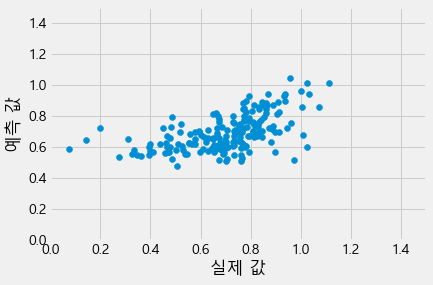

In [274]:
# 예측값과 실제값의 시각화
plt.scatter(y_test, y_predict)
plt.xlabel("실제 값")
plt.ylabel("예측 값")
plt.xlim(0,1.5)
plt.ylim(0,1.5)

In [275]:
predict = result[result['시즌']==2018] # 2018년도 데이터 프레임
predict = pd.concat([predict, pd.get_dummies(predict['포지션'], drop_first=True)], axis=1) # 포지션 dummy variable로 변환

# Dacon regular season과 submission 병합
# 추후 statiz data와 병합할 때 기준이 되는 생일 데이터를 얻기 위함
reg_sub = pd.merge(submission, reg[reg['year']==2018], on='batter_id', how='left', suffixes=['','_reg'])

# regular season dataframe의 생일 데이터를 statiz와 일치시킴
reg_sub['year_born'] = reg_sub['year_born'].apply(lambda x: datetime.strptime(x, "%Y년 %m월 %d일").date())
reg_sub['year_born'] = reg_sub['year_born'].astype(str)

# 필요한 feature만 남김
reg_sub = reg_sub[['batter_name', 'year_born', 'batter_id']]

# 이름과 생일을 기준으로 dacon data와 statiz data 병합
total = pd.merge(reg_sub, predict, how='left', left_on=['batter_name', 'year_born'], right_on=['이름', '생일'])

X = total[X_cols] # 사용 feature
X = X.fillna(-1) # NA값 -1로 impute

# 예측
total['y_hat'] = model.predict(X)

# 타자별 예측값 feature에 저장
submission['batter_ops'] = submission['batter_id'].apply(lambda x: total[total['batter_id']==x]['y_hat'].values[0])

In [277]:
# 제출 파일 생성
submission.to_csv("tnt_submission.csv", index=False, encoding='utf-8')

# 제출 결과 확인
sub = pd.read_csv('tnt_submission.csv')
sub

,batter_id,batter_name,batter_ops
0,1,강경학,0.659754
1,2,강구성,0.546199
2,3,강민국,0.603502
3,4,강민호,0.853124
4,5,강백호,0.893225
...,...,...,...
215,337,홍재호,0.589304
216,338,홍창기,0.650118
217,341,황윤호,0.565642
218,342,황재균,0.892056
